 <font size="+2"><p style="text-align: center;"><b> Auswertung Versuch 212 PAP 2.1. </p></font>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.odr import Data, RealData, Model, ODR
import pandas as pd

In [2]:
rho_f = 1.1466*1e3
Drho_f = 0.0006e3
Drho_k = 0.0025*1e3
g = 9.81
R = 75e-3/2

In [3]:
def get_rho_k(radius):
    if 2*radius < 2e3:
        return 1.3925e3
    elif 2*radius <= 7.144e3:
        return 1.3775e3
    elif 2*radius <= 8e3:
        return 1.3575e3
    else:
        return 1.3625e3
    
v_rho_k = np.vectorize(get_rho_k)

In [4]:
diameter = np.array([1.5, 2, 3, 4, 5, 6, 7.144, 8, 9])*1e-3
r = diameter/2
Dr = 1e-2*r

In [5]:
distance = np.array([20, 20, 20, 30, 30, 30, 30, 30, 30])*1e-2

In [6]:
rho_k = v_rho_k(r); print(rho_k)

[1392.5 1392.5 1392.5 1392.5 1392.5 1392.5 1392.5 1392.5 1392.5]


In [7]:
times = np.loadtxt('times.txt')

In [8]:
avg_time = np.average(times, axis = 1); print(avg_time)
Davg_time_std = 1/np.sqrt(5)*np.std(times, axis = 1)
Davg_time = Davg_time_std; print(Davg_time)

[124.48   78.68   39.694  34.45   22.656  16.53   12.234  11.116   8.692]
[2.98179543 0.63563512 0.32441455 0.23044305 0.14429414 0.10590562
 0.06762248 0.01930803 0.03615522]


In [9]:
v = distance/avg_time; print(v)
Dv = v*Davg_time/avg_time; print(Dv/v*100)

[0.00160668 0.00254194 0.00503854 0.00870827 0.01324153 0.01814882
 0.02452182 0.02698813 0.0345145 ]
[2.39540121 0.80787381 0.81728863 0.66892032 0.63689153 0.64068735
 0.55274221 0.17369584 0.41595974]


In [10]:
def get_ladenburg(radius):
    return 1 + 2.1*radius/R

ladenburg = get_ladenburg(r); print(ladenburg)

[1.042    1.056    1.084    1.112    1.14     1.168    1.200032 1.224
 1.252   ]


In [11]:
Dy = v/(rho_k - rho_f)*np.sqrt((Dv/v)**2 + (Drho_k/(rho_k - rho_f))**2)

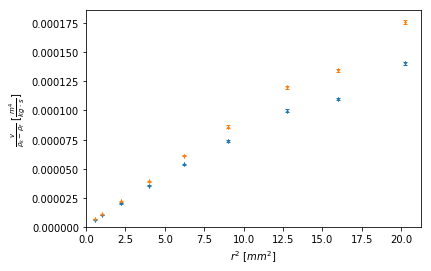

In [12]:
plt.errorbar(r**2*1e6, v/(rho_k - rho_f), xerr = 0, yerr = Dy, marker = '.', linestyle = 'none', markersize = 3, elinewidth = 1, capsize = 2)
plt.errorbar(r**2*1e6, ladenburg*v/(rho_k - rho_f), xerr = 0, yerr = ladenburg*Dy, marker = '.', linestyle = 'none', markersize = 3, elinewidth = 1, capsize = 2)
plt.xlabel(r"$r^2$ [${mm}^2$]")
plt.ylabel(r"$\frac{v}{\rho_k - \rho_f}$ [$\frac{m^4}{kg \cdot s}$]")
plt.xlim(left = 0)
plt.ylim(bottom = 0)
plt.savefig('figures/v_for_radii.png', format = 'png')

In [13]:
def fit_func_v(radius, visc):
    return 1/get_ladenburg(radius)*2/9*g*(v_rho_k(radius) - rho_f)/visc*radius**2

In [14]:
# number of radii for which Stoke's law seems to hold:
num_linear = 5
popt, pcov = curve_fit(fit_func_v, r[0:num_linear], v[0:num_linear], sigma = Dv[0:num_linear], p0 = [1])
eta = popt[0]
print("Viskosität: ", eta, " +- ", np.sqrt(pcov[0][0]))

('Viskosit\xc3\xa4t: ', 0.21683451508927512, ' +- ', 0.005099471793949987)


In [15]:
chi2_ = np.sum((fit_func_v(r[0:num_linear], *popt) - v[0:num_linear])**2/Dv[0:num_linear]**2)
dof = num_linear - 1
chi2_red = chi2_/dof
print("chi2 = ", chi2_)
print("chi2_red = ", chi2_red)

('chi2 = ', 174.471927798923)
('chi2_red = ', 43.61798194973075)


In [16]:
def fit_func_odr(visc, radius):
    return 1/get_ladenburg(radius)*2/9*g*(v_rho_k(radius) - rho_f)/visc[0]*radius**2

In [17]:
stokes = Model(fit_func_odr)
data = RealData(r[0:num_linear], y = v[0:num_linear], sx = Dr[0:num_linear], sy = Dv[0:num_linear])

In [18]:
odr = ODR(data, stokes, beta0 = [1])
output = odr.run()
output.pprint()
eta_odr = output.beta[0]
Deta_odr = output.sd_beta[0]

Beta: [0.21227653]
Beta Std Error: [0.00724349]
Beta Covariance: [[4.3604353e-06]]
Residual Variance: 12.0327847085
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


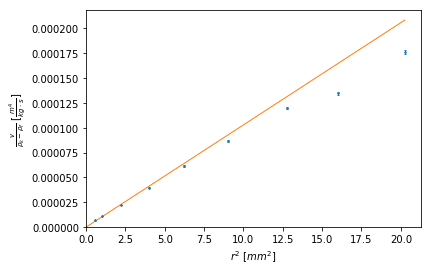

In [19]:
plt.errorbar(r**2*1e6, ladenburg*v/(rho_k - rho_f), xerr = 0, yerr = ladenburg*Dy, marker = '.', linestyle = 'none', markersize = 3, elinewidth = 1, capsize = 1)

r_cont = np.linspace(0, 4.5e-3, 100)
plt.plot(r_cont**2*1e6, get_ladenburg(r_cont)*fit_func_v(r_cont, eta_odr)/(v_rho_k(r_cont) - rho_f), linewidth = 1)
plt.xlabel(r"$r^2$ [${mm}^2$]")
plt.ylabel(r"$\frac{v}{\rho_k - \rho_f}$ [$\frac{m^4}{kg \cdot s}$]")
plt.xlim(left = 0)
plt.ylim(bottom = 0)
plt.savefig('figures/v_for_radii_fit.png', format = 'png')

In [20]:
Re = rho_f*v*2*r/eta_odr; print(Re)
DRe = Re*np.sqrt((Dr/r)**2 + (Dv/v)**2 + (Deta_odr/eta_odr)**2); print(DRe/Re)

[0.01301762 0.02746032 0.08164627 0.18814903 0.35761686 0.58817913
 0.94624627 1.16619899 1.67785337]
[0.04287386 0.03646421 0.03648519 0.03618174 0.0361239  0.03613061
 0.03598507 0.03560042 0.03580049]


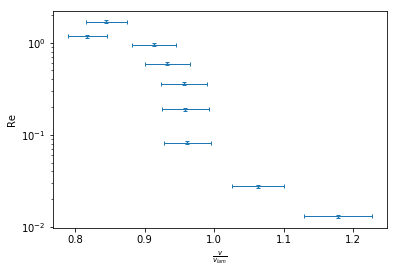

In [21]:
v_lam = fit_func_v(r, eta_odr)
Dv_lam = v_lam*Deta_odr/eta_odr
ratio = v/v_lam
Dratio = ratio*np.sqrt((Dv/v)**2 + (Dv_lam/v_lam)**2)
fig, ax = plt.subplots(1,1)
ax.errorbar(ratio, Re, xerr = Dratio, yerr = DRe, marker = '.', linestyle = 'none', markersize = 3, elinewidth = 1, capsize = 2)
ax.set_yscale('log')
ax.set_xlabel(r"$\frac{v}{v_{lam}}$")
ax.set_ylabel("Re")
fig.savefig('figures/reynolds.png', format = 'png')

In [22]:
print("Kritische Reynoldszahl liegt zwischen ", Re[1], " und ", Re[2])
print("Re_krit = ", (Re[1] + Re[2])/2, " +- ", (Re[2] - Re[1])/2)

('Kritische Reynoldszahl liegt zwischen ', 0.027460320244717642, ' und ', 0.08164626883865511)
('Re_krit = ', 0.05455329454168638, ' +- ', 0.027092974296968733)


In [23]:
table_data = np.vstack((fit_func_v(r, eta_odr)*1e2, v*1e2, v/fit_func_v(r, eta_odr), Re))
pd.DataFrame(table_data, index = ["$v_{\text{lam}}$", "$v$", r"$\frac{v}{v_{\text{lam}}}$", "$Re$"])

,0,1,2,3,4,5,6,7,8
$v_{\text{lam}}$,0.136323,0.239138,0.524163,0.908381,1.384485,1.945865,2.684993,3.301046,4.084451
$v$,0.160668,0.254194,0.503854,0.870827,1.324153,1.814882,2.452182,2.698813,3.451450
$\frac{v}{v_{\text{lam}}}$,1.178589,1.062959,0.961256,0.958658,0.956423,0.932687,0.913292,0.817563,0.845022
$Re$,0.013018,0.027460,0.081646,0.188149,0.357617,0.588179,0.946246,1.166199,1.677853


In [24]:
table_err = np.vstack((fit_func_v(r, eta_odr)*Deta_odr/eta_odr*1e2, Dv*1e2, DRe))
pd.DataFrame(table_err)

,0,1,2,3,4,5,6,7,8
0,0.004652,0.008160,0.017886,0.030997,0.047243,0.066399,0.091620,0.112641,0.139373
1,0.003849,0.002054,0.004118,0.005825,0.008433,0.011628,0.013554,0.004688,0.014357
2,0.000558,0.001001,0.002979,0.006808,0.012919,0.021251,0.034051,0.041517,0.060068


## Hagen-Poiseuille 

In [25]:
h_A = 540e-3
h_E = 534e-3
h = (h_A + h_E)/2
Dh = 2e-3/np.sqrt(2); Dh/h

0.0026335448088884448

In [26]:
rho_f = 1.1460e3

In [27]:
# pressure difference:
p = h*rho_f*g
Dp = p*np.sqrt((Dh/h)**2 + (Drho_f/rho_f)**2); Dp/p

0.0026850835281822176

In [28]:
# capillary:
L = 100e-3
DL = 0.5e-3
R = 1.5e-3/2
DR = 0.01e-3/2

In [29]:
vol = np.array([0, 5, 10, 15, 20, 25])*1e-6
time = np.array([0, 104, 236, 364, 498, 630])
Dvol = 0.5e-6
Dtime = 5.0

In [30]:
# check for errors:
flow = (np.concatenate((vol[1:], [0])) - np.concatenate(([0], vol[1:]))) / (np.concatenate((time[1:], [0])) - np.concatenate(([0], time[1:])))
print(flow)

[4.80769231e-08 3.78787879e-08 3.90625000e-08 3.73134328e-08
 3.78787879e-08 3.96825397e-08]


In [31]:
total_time = time[5] - time[0]
total_vol = vol[5] - vol[0]
avg_flow = total_vol/total_time
print(avg_flow)

Dtotal_time = np.sqrt(2)*Dtime
Dtotal_vol = np.sqrt(2)*Dvol
Davg_flow = avg_flow*np.sqrt((Dtotal_time/total_time)**2 + (Dtotal_vol/total_vol)**2)
print(Davg_flow)

3.968253968253968e-08
1.2075340857971035e-09


In [32]:
eta_hp = np.pi*p*R**4 / (8*avg_flow*L)
Deta_hp = eta_hp * np.sqrt((4*DR/R)**2 + (Davg_flow/avg_flow)**2 + (DL/L)**2)
print("Vsicosity: ", eta_hp, " +- ", Deta_hp)

('Vsicosity: ', 0.18903115623357136, ' +- ', 0.007706555722928347)


In [33]:
# Reynolds number:
Re_hp = rho_f*avg_flow*2*R / (np.pi*R**2*eta_hp)
print(Re_hp)

0.2042064924177512


In [34]:
# deviation:
combined_error = np.sqrt(Deta_odr**2 + Deta_hp**2)
sigma_val = abs(eta_hp - eta_odr) / combined_error
print(sigma_val)

2.197863504475689
